
# **Contents**

1. Business Problem Understanding
2. Data Understanding
3. Data Preprocessing
4. Modeling
5. Conclusion
6. Recommendation

****

## 1. **Business Problem Understanding**

Arab Saudi memiliki pasar mobil bekas yang dinamis, dengan banyak pembeli yang mencari kendaraan berkualitas sesuai dengan kebutuhan dan anggaran mereka. Namun, variasi dalam jenis mobil, kondisi, dan harga dapat membuat pembeli kesulitan dalam mengambil keputusan. Oleh karena itu, tujuan dari analisis ini adalah:

- Memahami faktor-faktor yang memengaruhi harga mobil bekas di Arab Saudi.

- Membangun model prediksi untuk memperkirakan harga mobil berdasarkan atributnya.

- Memberikan rekomendasi kepada penjual dan pembeli untuk membantu mereka membuat keputusan yang lebih baik.



## **2. Data Understanding**

Dataset berisi informasi tentang mobil bekas yang dijual di Arab Saudi, terdiri dari 11 atribut:

- Type: Jenis mobil (contoh: Corolla, Yukon).

- Region: Lokasi penjualan (contoh: Abha, Riyadh).

- Make: Merek mobil (contoh: Toyota, GMC).

- Gear_Type: Jenis transmisi (Manual/Automatic).

- Origin: Asal mobil (contoh: Saudi, Gulf Arabic).

- Options: Tingkat kelengkapan (Standard, Semi Full, Full).

- Year: Tahun produksi mobil.

- Engine_Size: Ukuran mesin (liter).

- Mileage: Jarak tempuh (kilometer).

- Negotiable: Apakah harga bisa dinegosiasikan (True/False).

- Price: Harga mobil (kurs dalam Riyal Saudi).

Dataset terdiri dari 5624 baris data tanpa nilai yang hilang. Kolom Price adalah target yang akan diprediksi.

In [1]:
# Library

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

from scipy.stats import chi2_contingency

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, recall_score, accuracy_score, precision_score, f1_score, make_scorer
from sklearn.ensemble import VotingClassifier, StackingClassifier

from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE

from imblearn.pipeline import Pipeline

warnings.filterwarnings('ignore')




In [2]:
df = pd.read_csv("data_saudi_used_cars.csv")
df

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
4,FJ,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.0,49000,True,0
...,...,...,...,...,...,...,...,...,...,...,...
5619,X-Trail,Jeddah,Nissan,Automatic,Saudi,Standard,2018,2.5,78794,False,68000
5620,Altima,Jeddah,Nissan,Automatic,Saudi,Semi Full,2020,2.5,58000,True,0
5621,Yukon,Dammam,GMC,Automatic,Saudi,Full,2016,5.3,48000,False,145000
5622,RX,Dammam,Lexus,Automatic,Gulf Arabic,Full,2016,2.5,81000,False,154000


In [3]:
# Extract General Information (Nama Kolom, Tipe Data, Missing Value, % Missing Value, Unique, Sample Unique)

list_item = []

for i in df.columns :
    list_item.append([
        i,
        df[i].dtype,
        df[i].isna().sum(),
        round(df[i].isna().sum()/len(df), 2),
        df[i].nunique(),
        df[i].unique()[:3]
    ])

info_df = pd.DataFrame(list_item,
                       columns='Nama Kolom, Tipe Data, Missing Value, % Missing Value, N Unique, Unique Sample'.split(', '))

info_df

,Nama Kolom,Tipe Data,Missing Value,% Missing Value,N Unique,Unique Sample
0,Type,object,0,0.0,347,"[Corolla, Yukon, Range Rover]"
1,Region,object,0,0.0,27,"[Abha, Riyadh, Hafar Al-Batin]"
2,Make,object,0,0.0,58,"[Toyota, GMC, Land Rover]"
3,Gear_Type,object,0,0.0,2,"[Manual, Automatic]"
4,Origin,object,0,0.0,4,"[Saudi, Gulf Arabic, Other]"
5,Options,object,0,0.0,3,"[Standard, Full, Semi Full]"
6,Year,int64,0,0.0,50,"[2013, 2014, 2015]"
7,Engine_Size,float64,0,0.0,71,"[1.4, 8.0, 5.0]"
8,Mileage,int64,0,0.0,1716,"[421000, 80000, 140000]"
9,Negotiable,bool,0,0.0,2,"[True, False]"


## **3. Data Preprocessing**

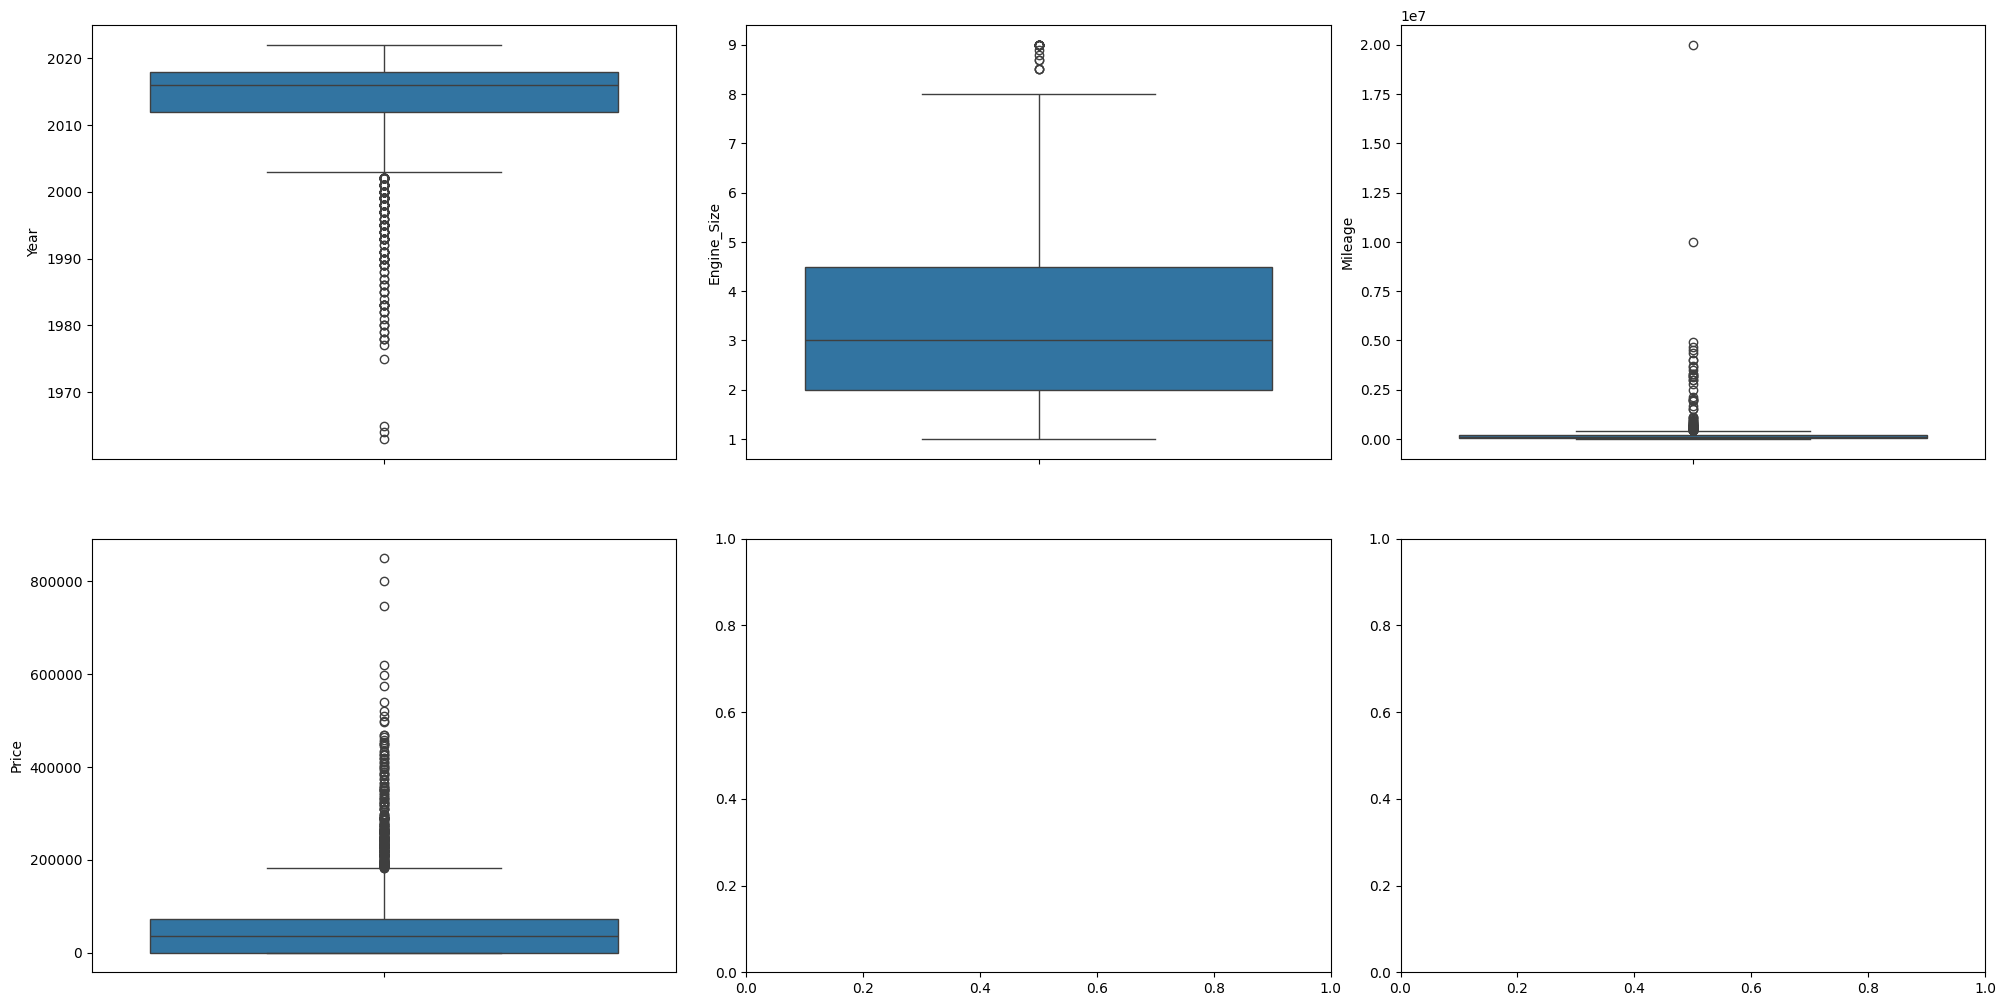

In [4]:
# Outlier Detection
numericCols = df.drop(['Type','Region','Make','Gear_Type','Origin', 'Options', 'Negotiable'],axis=1).select_dtypes(include=[float, int]).columns
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20,10))
index = 0
ax = ax.flatten()
for col in numericCols:
    sns.boxplot(y=col, data=df, ax=ax[index])
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.show()

In [ ]:
# Take Out Outliers Extreme / Tidak Masuk Akal

df = df[(df['Price'] > 3000) & (df['Price'] < 250000)]
df = df[(df['Year'] > 1978)] 

df

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
5,CX3,Abha,Mazda,Automatic,Saudi,Semi Full,2019,2.0,25000,False,58000
6,Cayenne S,Riyadh,Porsche,Automatic,Saudi,Full,2012,4.8,189000,False,85000
7,Sonata,Riyadh,Hyundai,Automatic,Saudi,Full,2016,2.4,155,False,48000
...,...,...,...,...,...,...,...,...,...,...,...
5616,CX9,Qassim,Mazda,Automatic,Saudi,Full,2020,2.0,9500,False,132000
5618,Suburban,Riyadh,GMC,Automatic,Saudi,Full,2006,5.3,86000,False,50000
5619,X-Trail,Jeddah,Nissan,Automatic,Saudi,Standard,2018,2.5,78794,False,68000
5621,Yukon,Dammam,GMC,Automatic,Saudi,Full,2016,5.3,48000,False,145000


In [6]:
# Drop Duplicate

df = df.drop_duplicates()

In [ ]:
# Clear Missing Values

df[df.Origin == 'Unknown']

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
276,Charger,Riyadh,Dodge,Automatic,Unknown,Full,2020,3.6,9120,False,115000
665,Grand Marquis,Al-Medina,Mercury,Automatic,Unknown,Full,2007,4.6,179000,False,24000
800,Camry,Qassim,Toyota,Automatic,Unknown,Full,2005,2.5,437000,False,13000
1174,Camry,Abha,Toyota,Automatic,Unknown,Standard,2017,2.5,120000,False,59000
1376,ES,Jeddah,Lexus,Automatic,Unknown,Full,2021,3.5,1300,False,175000
1392,Focus,Jeddah,Ford,Automatic,Unknown,Standard,2011,1.6,181000,False,10000
1989,Camry,Al-Medina,Toyota,Automatic,Unknown,Full,2020,2.5,10616,False,104500
2147,Tahoe,Al-Ahsa,Chevrolet,Automatic,Unknown,Semi Full,2008,5.3,247000,False,42500
2613,Optima,Tabouk,Kia,Automatic,Unknown,Semi Full,2018,2.4,125000,False,55000
3209,Furniture,Al-Ahsa,Toyota,Automatic,Unknown,Semi Full,2017,2.7,70000,False,75000


In [8]:
# Replace Unknown to NaN
df.replace(to_replace='Unknown', value=np.nan)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
5,CX3,Abha,Mazda,Automatic,Saudi,Semi Full,2019,2.0,25000,False,58000
6,Cayenne S,Riyadh,Porsche,Automatic,Saudi,Full,2012,4.8,189000,False,85000
7,Sonata,Riyadh,Hyundai,Automatic,Saudi,Full,2016,2.4,155,False,48000
...,...,...,...,...,...,...,...,...,...,...,...
5616,CX9,Qassim,Mazda,Automatic,Saudi,Full,2020,2.0,9500,False,132000
5618,Suburban,Riyadh,GMC,Automatic,Saudi,Full,2006,5.3,86000,False,50000
5619,X-Trail,Jeddah,Nissan,Automatic,Saudi,Standard,2018,2.5,78794,False,68000
5621,Yukon,Dammam,GMC,Automatic,Saudi,Full,2016,5.3,48000,False,145000


In [9]:
# Remove NaN
df = df.dropna(axis=0)
df

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
5,CX3,Abha,Mazda,Automatic,Saudi,Semi Full,2019,2.0,25000,False,58000
6,Cayenne S,Riyadh,Porsche,Automatic,Saudi,Full,2012,4.8,189000,False,85000
7,Sonata,Riyadh,Hyundai,Automatic,Saudi,Full,2016,2.4,155,False,48000
...,...,...,...,...,...,...,...,...,...,...,...
5616,CX9,Qassim,Mazda,Automatic,Saudi,Full,2020,2.0,9500,False,132000
5618,Suburban,Riyadh,GMC,Automatic,Saudi,Full,2006,5.3,86000,False,50000
5619,X-Trail,Jeddah,Nissan,Automatic,Saudi,Standard,2018,2.5,78794,False,68000
5621,Yukon,Dammam,GMC,Automatic,Saudi,Full,2016,5.3,48000,False,145000


In [10]:
# Drop Negotiable karena tidak perlu

df = df.drop(['Negotiable'], axis=1)
df

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Price
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,120000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,42000
5,CX3,Abha,Mazda,Automatic,Saudi,Semi Full,2019,2.0,25000,58000
6,Cayenne S,Riyadh,Porsche,Automatic,Saudi,Full,2012,4.8,189000,85000
7,Sonata,Riyadh,Hyundai,Automatic,Saudi,Full,2016,2.4,155,48000
...,...,...,...,...,...,...,...,...,...,...
5616,CX9,Qassim,Mazda,Automatic,Saudi,Full,2020,2.0,9500,132000
5618,Suburban,Riyadh,GMC,Automatic,Saudi,Full,2006,5.3,86000,50000
5619,X-Trail,Jeddah,Nissan,Automatic,Saudi,Standard,2018,2.5,78794,68000
5621,Yukon,Dammam,GMC,Automatic,Saudi,Full,2016,5.3,48000,145000


## **4. Modeling**

In [11]:
# List Model/ Algoritma

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

linreg = LinearRegression()
knnreg = KNeighborsRegressor()
treereg = DecisionTreeRegressor()
svreg = SVR()
rfreg = RandomForestRegressor()
xgbreg = XGBRegressor()
ridgereg = Ridge()
lassoreg = Lasso()
gradientreg = GradientBoostingRegressor()
adaboostreg = AdaBoostRegressor()
normalModel = [linreg,knnreg,treereg,svreg,rfreg,xgbreg,ridgereg,lassoreg,gradientreg]
normalModelName = ['linreg','knnreg','treereg','svreg','rfreg','xgbreg','ridgereg','lassoreg','gradientreg', 'adaboostreg']

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3621 entries, 1 to 5622
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Type         3621 non-null   object 
 1   Region       3621 non-null   object 
 2   Make         3621 non-null   object 
 3   Gear_Type    3621 non-null   object 
 4   Origin       3621 non-null   object 
 5   Options      3621 non-null   object 
 6   Year         3621 non-null   int64  
 7   Engine_Size  3621 non-null   float64
 8   Mileage      3621 non-null   int64  
 9   Price        3621 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 311.2+ KB


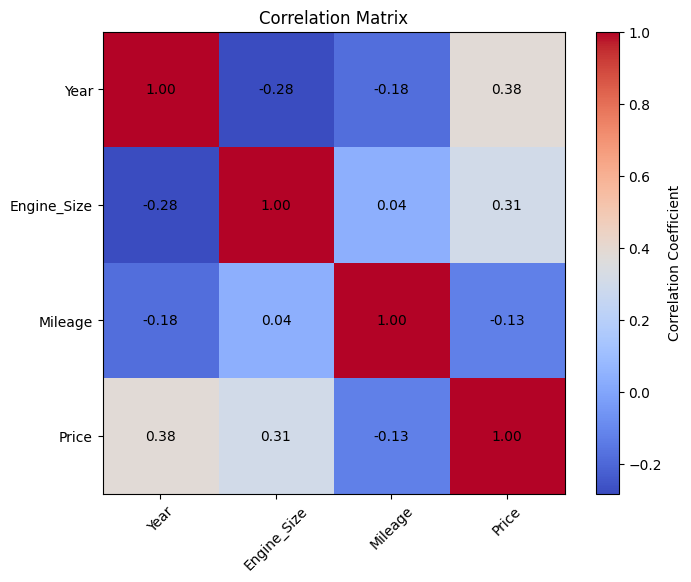

,Year,Engine_Size,Mileage,Price
Year,1.000000,-0.282475,-0.179801,0.381597
Engine_Size,-0.282475,1.000000,0.038694,0.305287
Mileage,-0.179801,0.038694,1.000000,-0.125957
Price,0.381597,0.305287,-0.125957,1.000000


In [13]:
# Calculate the correlation matrix for numeric columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numeric_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label="Correlation Coefficient")
plt.xticks(np.arange(len(numeric_columns)), numeric_columns, rotation=45)
plt.yticks(np.arange(len(numeric_columns)), numeric_columns)

# Annotate each cell with the correlation value
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                 ha="center", va="center", color="black")\
                 
plt.title("Correlation Matrix")
plt.show()

correlation_matrix


In [14]:
# Mengubah fitur kategorikal menjadi numerikal
transformer = ColumnTransformer([

    ('OHE', OneHotEncoder(drop='first'), ['Gear_Type', 'Origin', 'Options']),
    ('Binary', ce.BinaryEncoder(), ['Type', 'Region', 'Make']),
], remainder='passthrough')

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('OHE', OneHotEncoder(drop='first'),
                                 ['Gear_Type', 'Origin', 'Options']),
                                ('Binary', BinaryEncoder(),
                                 ['Type', 'Region', 'Make'])])

In [15]:
# Split Train Test

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline

X = df.drop(['Price'], axis=1)
y = df['Price']

               


In [16]:
# Splitting data training dan test dengan proporsi 70:30
X_train, X_test, y_train, y_test= train_test_split(
    X,
    y,  
    test_size=0.3,
    random_state=1)

In [17]:
# Library 

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [18]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np

In [19]:
# Define algoritma yang digunakan
lr = LinearRegression()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor(random_state=1)
rf = RandomForestRegressor(random_state=1)
xgb = XGBRegressor(random_state=1)

# Pemodelan dilakukan dalam skala logaritmik, namun kemudian di-inverse kembali untuk interpretasi
log_lr = TransformedTargetRegressor(lr, func=np.log, inverse_func=np.exp)
log_knn = TransformedTargetRegressor(knn, func=np.log, inverse_func=np.exp)
log_dt = TransformedTargetRegressor(dt, func=np.log, inverse_func=np.exp)
log_rf = TransformedTargetRegressor(rf, func=np.log, inverse_func=np.exp)
log_xgb = TransformedTargetRegressor(xgb, func=np.log, inverse_func=np.exp)

# Scaling data
scaler = StandardScaler()

# Kandidat algoritma
models = [log_lr, log_knn, log_dt, log_rf, log_xgb]

score_rmse = []
nilai_mean_rmse = []
nilai_std_rmse = []

score_mae = []
nilai_mean_mae = []
nilai_std_mae = []

score_mape = []
nilai_mean_mape = []
nilai_std_mape = []

# Mencari algoritma terbaik berdasarkan tiap metrics
for i in models:
    
    crossval = KFold(n_splits=5, shuffle=True, random_state=1)

    estimator = Pipeline([
        ('preprocessing', transformer),
        ('scaler', scaler),
        ('model', i)
    ])

    # RMSE
    model_cv_rmse = cross_val_score(
        estimator, 
        X_train, 
        y_train, 
        cv=crossval, 
        scoring='neg_root_mean_squared_error', 
        error_score='raise'
        )

    print(model_cv_rmse, i)

    score_rmse.append(model_cv_rmse)
    nilai_mean_rmse.append(model_cv_rmse.mean())
    nilai_std_rmse.append(model_cv_rmse.std())

    # MAE
    model_cv_mae = cross_val_score(
        estimator, 
        X_train, 
        y_train, 
        cv=crossval, 
        scoring='neg_mean_absolute_error', 
        error_score='raise'
        )

    print(model_cv_mae, i)

    score_mae.append(model_cv_mae)
    nilai_mean_mae.append(model_cv_mae.mean())
    nilai_std_mae.append(model_cv_mae.std())

    # MAPE
    model_cv_mape = cross_val_score(
        estimator, 
        X_train, 
        y_train, 
        cv=crossval, 
        scoring='neg_mean_absolute_percentage_error', 
        error_score='raise'
        )

    print(model_cv_mape, i)

    score_mape.append(model_cv_mape)
    nilai_mean_mape.append(model_cv_mape.mean())
    nilai_std_mape.append(model_cv_mape.std())

[-34301.00669861 -32503.77825305 -30531.2673523  -35479.07080536
 -31344.58847942] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-22070.08684044 -21942.71519091 -20337.12409155 -22181.00909074
 -19776.99546092] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-0.33427988 -0.36538201 -0.36082045 -0.51995662 -0.33387834] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-34119.32455405 -32969.48574001 -30275.6492061  -33581.33942504
 -33006.17897355] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=KNeighborsRegressor())
[-22851.32045982 -22042.48032796 -20490.45223139 -21438.759021
 -21142.90395765] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
  

In [20]:
# Evaluasi hasil dari 5 kandidat algoritma yang digunakan
pd.DataFrame({
    'Model': ['Linear Regression', 'KNN Regressor', 'DecisionTree Regressor', 'RandomForest Regressor', 'XGBoost Regressor'],
    'Mean_RMSE': nilai_mean_rmse,
    'Std_RMSE': nilai_std_rmse,
    'Mean_MAE': nilai_mean_mae,
    'Std_MAE': nilai_std_mae,
    'Mean_MAPE': nilai_mean_mape,
    'Std_MAPE': nilai_std_mape
})

,Model,Mean_RMSE,Std_RMSE,Mean_MAE,Std_MAE,Mean_MAPE,Std_MAPE
0,Linear Regression,-32831.942318,1831.854676,-21261.586135,1002.156504,-0.382863,0.069780
1,KNN Regressor,-32790.395580,1326.214875,-21593.183200,803.416590,-0.453975,0.028773
2,DecisionTree Regressor,-31555.490593,2741.476286,-19068.061160,1338.219194,-0.355645,0.067884
3,RandomForest Regressor,-24306.648005,3043.058487,-14442.055636,1177.056123,-0.253985,0.049755
4,XGBoost Regressor,-22476.878120,2652.664677,-13555.110965,1058.626509,-0.244435,0.049537


Terdapat perbedaan cukup signifikan antara nilai RMSE dan MAE, di mana nilai RMSE lebih tinggi karena nilai residuals atau error-nya dikuadratkan terlebih dahulu sebelum dirata-ratakan. Hal ini menyebabkan RMSE akan memberikan 'weight' yang lebih tinggi untuk nilai error yang besar. Dengan kata lain, terdapat nilai-nilai error yang besar yang dihasilkan oleh semua algoritma yang digunakan, sehingga ada perbedaan signifikan antara nilai RMSE dan MAE.

- Berdasarkan nilai RMSE, Random Forest adalah model terbaik. Sedangkan jika berdasarkan nilai MAE dan MAPE, XGBoost memiliki nilai paling rendah.
- Selanjutnya, akan dilakukan prediksi pada test set dengan 2 benchmark model terbaik, yaitu Random Forest dan XGBoost. 

In [21]:
# Benchmark 2 model terbaik
models = {
    'Random Forest': RandomForestRegressor(random_state=1),
    'XGB': XGBRegressor(random_state=1)
}

score_rmse = []
score_mae = []
score_mape = []

# Prediksi pada test set
for i in models:

    model = Pipeline([
        ('preprocessing', transformer),
        ('scaler', scaler),
        ('model', models[i])
        ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    score_mae.append(mean_absolute_error(y_test, y_pred))
    score_mape.append(mean_absolute_percentage_error(y_test, y_pred))

score_before_tuning = pd.DataFrame({'RMSE': score_rmse, 'MAE': score_mae, 'MAPE': score_mape}, index=models.keys())
score_before_tuning

,RMSE,MAE,MAPE
Random Forest,22992.323672,14885.552076,0.289387
XGB,19576.110951,12921.619335,0.251699


- Ketika dilakukan prediksi pada test set, performa XGBoost secara akumulatif sedikit lebih baik. Hal ini dapat dilihat dari nilai RMSE MAE dan MAPE yang lebih rendah dari Decision Tree.


**Hyperparameter Tuning**

Karena model XGBoost memiliki performa yang sedikit lebih baik dari RandomForest, maka selanjutnya kita akan menggunakan model XGBoost ini sebagai model akhir. Pada tahap ini, kita akan melakukan hyperparameter tuning pada model XGBoost dengan harapan dapat meningkatkan performa model.

In [22]:
# Kedalaman pohon
max_depth = list(np.arange(1, 11))

# Learning rate
learning_rate = list(np.arange(1, 100)/100)

# Jumlah pohon
n_estimators = list(np.arange(100, 201))

# Jumlah baris tiap pohon (% dari total baris train set)
subsample = list(np.arange(2, 10)/10)

# Gamma (min_impurity_decrease)
gamma = list(np.arange(1, 11)) # Semakin besar nilainya, semakin konservatif/simpel modelnya

# Jumlah feature yang digunakan untuk tiap pohon (% dari total kolom train set)
colsample_bytree = list(np.arange(1, 10)/10)

# Alpha (regularization)
reg_alpha = list(np.logspace(-3, 1, 10)) # Semakin besar nilainya, semakin konservatif/simpel modelnya


# Hyperparam space XGboost
hyperparam_space_xgb = {
    'model__max_depth': max_depth, 
    'model__learning_rate': learning_rate,
    'model__n_estimators': n_estimators,
    'model__subsample': subsample,
    'model__gamma': gamma,
    'model__colsample_bytree': colsample_bytree,
    'model__reg_alpha': reg_alpha
}

In [23]:
# Benchmark model dengan hyperparameter tuning
xgb = XGBRegressor(random_state=1, verbosity=0)

# Membuat algorithm chains
estimator_xgb = Pipeline([
        ('preprocessing', transformer),
        ('scaler', scaler),
        ('model', xgb)
        ])

crossval = KFold(n_splits=5, shuffle=True, random_state=1)

# Hyperparameter tuning
random_xgb = RandomizedSearchCV(
    estimator_xgb, 
    param_distributions = hyperparam_space_xgb,
    n_iter = 50,
    cv = crossval, 
    scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'], 
    n_jobs = -1,
    refit = 'neg_root_mean_squared_error', # Hanya bisa memilih salah stau metric untuk optimisasi
    random_state = 1  
)

In [24]:
# Fitting data training untuk mencari parameter terbaik
random_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('OHE',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Gear_Type',
                                                                                'Origin',
                                                                                'Options']),
                                                                              ('Binary',
                                                                               BinaryEncoder(),
                                                                               ['Type',
                                                                                'Region',
                                                                                'Make'])])),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              XGBRegressor(base_scor...
                                                             np.float64(3.593813663804626),
                                                             np.float64(10.0)],
                                        'model__subsample': [np.float64(0.2),
                                                             np.float64(0.3),
                                                             np.float64(0.4),
                                                             np.float64(0.5),
                                                             np.float64(0.6),
                                                             np.float64(0.7),
                                                             np.float64(0.8),
                                                             np.float64(0.9)]},
                   random_state=1, refit='neg_root_mean_squared_error',
                   scoring=['neg_root_mean_squared_error',
                            'neg_mean_absolute_error',
                            'neg_mean_absolute_percentage_error'])

In [25]:
# Melihat hasil tuning dalam bentuk dataframe. Diurutkan berdasarkan RMSE, MAE & MAPE
pd.DataFrame(random_xgb.cv_results_).sort_values(by=['rank_test_neg_root_mean_squared_error', 'rank_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_percentage_error']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__subsample,param_model__reg_alpha,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model__gamma,param_model__colsample_bytree,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
7,0.923730,0.163977,0.090359,0.045488,0.9,0.059948,119,8,0.05,5,0.8,"{'model__subsample': 0.9, 'model__reg_alpha': 0.05994842503189409, 'model__n_estimators': 119, 'model__max_depth': 8, 'model__learning_rate': 0.05, 'model__gamma': 5, 'model__colsample_bytree': 0.8}",-23086.904488,-21061.457705,-18592.295292,-25906.381185,-20077.135656,-21744.834865,2541.902807,1,-14207.191811,-13579.012214,-12426.598330,-15230.468586,-12869.669383,-13662.588065,991.788097,1,-0.278063,-0.250081,-0.279351,-0.393087,-0.259816,-0.292080,0.051703,2
17,0.598539,0.148893,0.034110,0.007203,0.6,0.001000,190,5,0.04,9,0.9,"{'model__subsample': 0.6, 'model__reg_alpha': 0.001, 'model__n_estimators': 190, 'model__max_depth': 5, 'model__learning_rate': 0.04, 'model__gamma': 9, 'model__colsample_bytree': 0.9}",-24424.675420,-22009.825332,-18698.349719,-24959.511280,-20717.699104,-22162.012171,2326.018267,2,-15206.827412,-14449.269244,-12630.544234,-15253.189082,-13350.840053,-14178.134005,1036.042204,2,-0.273398,-0.246889,-0.271228,-0.390464,-0.252631,-0.286922,0.052780,1
20,0.349665,0.115182,0.050467,0.020765,0.9,0.007743,143,4,0.38,6,0.8,"{'model__subsample': 0.9, 'model__reg_alpha': 0.007742636826811269, 'model__n_estimators': 143, 'model__max_depth': 4, 'model__learning_rate': 0.38, 'model__gamma': 6, 'model__colsample_bytree': 0.8}",-23973.715612,-21144.949466,-20815.645157,-24877.237074,-20873.142001,-22336.937862,1732.629657,3,-14688.495738,-14328.678476,-14164.287922,-15482.815536,-13961.897488,-14525.235032,534.767419,3,-0.260904,-0.271950,-0.298862,-0.417635,-0.275624,-0.304995,0.057661,3
23,0.428165,0.149859,0.056847,0.043327,0.9,3.593814,153,4,0.33,9,0.3,"{'model__subsample': 0.9, 'model__reg_alpha': 3.593813663804626, 'model__n_estimators': 153, 'model__max_depth': 4, 'model__learning_rate': 0.33, 'model__gamma': 9, 'model__colsample_bytree': 0.3}",-24731.256556,-20211.399155,-21328.509472,-26045.964120,-21236.678545,-22710.761569,2259.926112,4,-16056.302221,-13806.578670,-14474.399251,-16256.082288,-14144.452923,-14947.563070,1011.161744,6,-0.319395,-0.271160,-0.317600,-0.438171,-0.294696,-0.328205,0.057723,8
3,0.509437,0.022250,0.036901,0.009007,0.5,0.021544,166,8,0.10,9,0.3,"{'model__subsample': 0.5, 'model__reg_alpha': 0.021544346900318832, 'model__n_estimators': 166, 'model__max_depth': 8, 'model__learning_rate': 0.1, 'model__gamma': 9, 'model__colsample_bytree': 0.3}",-24415.965780,-21718.913720,-20761.857770,-25832.650708,-21143.776001,-22774.632796,1993.536931,5,-15688.077429,-14588.205757,-14251.828745,-15628.586753,-14088.957970,-14849.131331,680.308369,4,-0.307515,-0.274674,-0.321758,-0.428213,-0.307614,-0.327954,0.052460,7


In [26]:
# Cek skor dan params terbaik
print('XGBoost')
print('Best_score:', random_xgb.best_score_)
print('Best_params:', random_xgb.best_params_)

XGBoost
Best_score: -21744.834865224595
Best_params: {'model__subsample': np.float64(0.9), 'model__reg_alpha': np.float64(0.05994842503189409), 'model__n_estimators': np.int64(119), 'model__max_depth': np.int64(8), 'model__learning_rate': np.float64(0.05), 'model__gamma': np.int64(5), 'model__colsample_bytree': np.float64(0.8)}


**Predict to Test Set with the Tuned Model**

Melakukan prediksi pada test set dengan menggunakan model XGBoost dan hyperparameter terpilih.

In [27]:
# Model XGBoost
model = {'XGB': XGBRegressor(random_state=1)}

# Define model terhadap estimator terbaik
xgb_tuning = random_xgb.best_estimator_

# Fitting model
xgb_tuning.fit(X_train, y_train)

# Predict test set
y_pred_xgb_tuning = xgb_tuning.predict(X_test)

# Simpan nilai metrics RMSE, MAE & MAPE setelah tuning
rmse_xgb_tuning = np.sqrt(mean_squared_error(y_test, y_pred_xgb_tuning))
mae_xgb_tuning = mean_absolute_error(y_test, y_pred_xgb_tuning)
mape_xgb_tuning = mean_absolute_percentage_error(y_test, y_pred_xgb_tuning)

score_after_tuning = pd.DataFrame({'RMSE': rmse_xgb_tuning, 'MAE': mae_xgb_tuning, 'MAPE': mape_xgb_tuning}, index=model.keys())
score_after_tuning

,RMSE,MAE,MAPE
XGB,20263.818831,12956.295689,0.257784


**Performance Comparison**

Perbandingan performa model XGBoost sebelum dan sesudah dilakukan hyperparameter tuning.

In [28]:
# Sebelum hyperparameter tuning
pd.DataFrame(score_before_tuning.loc['XGB']).T

,RMSE,MAE,MAPE
XGB,19576.110951,12921.619335,0.251699


In [29]:
# Setelah hyperparameter tuning
score_after_tuning

,RMSE,MAE,MAPE
XGB,20263.818831,12956.295689,0.257784


Model mengalami penurunan performa (nilai RMSE, MAE & MAPE bertambah) dengan dilakukannya hyperparameter tuning, walaupun hanya sedikit.
- RMSE, MAE & MAPE sebelum tuning: 19576.110951	12921.619335	0.251699
- RMSE, MAE & MAPE setelah tuning: 20263.818831	12956.295689	0.257784

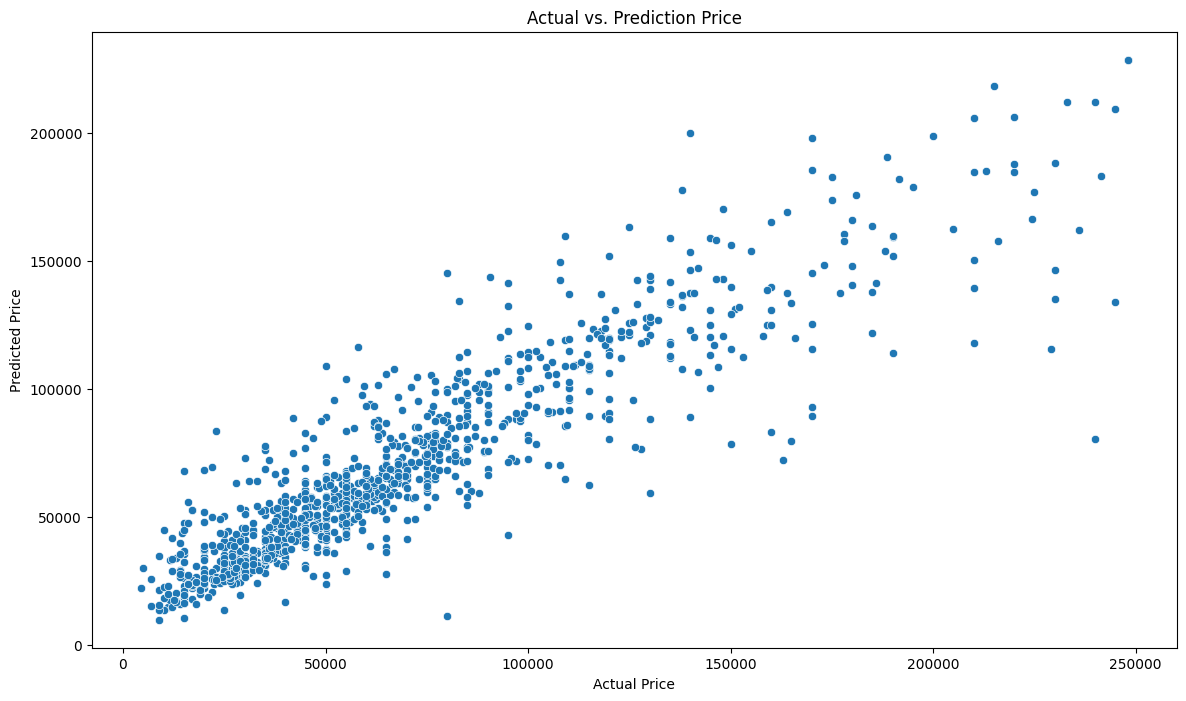

In [30]:
plt.figure(figsize=(14, 8))
plot = sns.scatterplot(x=y_test, y=y_pred_xgb_tuning).set(title='Actual vs. Prediction Price', 
                                               xlabel='Actual Price', 
                                               ylabel='Predicted Price');

Berdasarkan scatter plot menunjukkan bahwa hasil prediksi model tergolong baik. Nilai akhir dari evaluation metrix (MAPE) yang diperoleh sebesar 0.251699 atau 25%. 

Kemudian, pada hasil yang diperoleh menggambarkan adanya bias pada data. Hal ini dapat disebabkan oleh beberapa faktor, salah satunya multikolineritas atau terdapat hubungan yang kuat diantara independet variablenya. Untuk mencari penyebab dan mengatasinya akan dilakukan beberapa tahapan kembali hingga kita mendapatkan hasil model yang terbaik.

Untuk dapat mengetahui sebenarnya fitur apa saja yang sangat memengaruhi target (price), kita dapat mengeceknya melalui function feature_importances_.

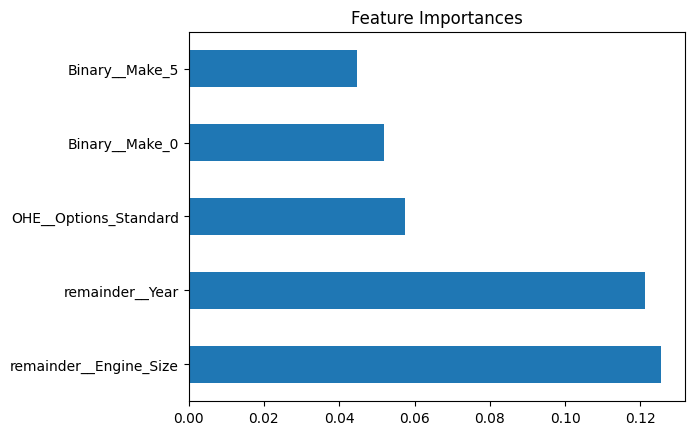

In [31]:
# Plot feature importances
feature_imp = pd.Series(xgb_tuning['model'].feature_importances_, transformer.get_feature_names_out()).sort_values(ascending = False).head()
feature_imp.plot(kind='barh', title='Feature Importances');

In [32]:
name = []
importance = []
for nam,imp in zip(transformer.get_feature_names_out(), xgb_tuning['model'].feature_importances_):
    name.append(nam)
    importance.append(round(imp*100,2))

In [33]:
feature = pd.DataFrame({'Features':name,'Importance(%)':importance})
feature.sort_values(by='Importance(%)',ascending=False)

,Features,Importance(%)
27,remainder__Engine_Size,12.55
26,remainder__Year,12.12
5,OHE__Options_Standard,5.75
20,Binary__Make_0,5.19
25,Binary__Make_5,4.47
23,Binary__Make_3,4.35
28,remainder__Mileage,4.10
21,Binary__Make_1,3.70
14,Binary__Type_8,3.64
22,Binary__Make_2,3.63


## **5. Conclusions**

Berdasarkan pemodelan yang sudah dilakukan, fitur 'Year', 'Engine Size', dan 'Make' menjadi fitur yang paling berpengaruh terhadap 'Price'.

Mungkin dikarenakan pembeli menginginkan Usia mobil yang tergolong muda dan ukuran mesin yang optimal serta merk mobil tertentu menjadi hal yang berpengaruh terhadap harga mobil.

 Metrik evaluasi yang digunakan pada model adalah nilai RMSE, MAE & MAPE. Jika ditinjau dari nilai MAPE yang dihasilkan oleh model setelah dilakukan hyperparameter tuning, yaitu sebesar ~25% dimana angka ini masih menunjukkan cukup dan wajar, kita dapat menyimpulkan bahwa bila nanti model yang kita buat ini digunakan untuk memperkirakan harga mobil.
 
 Tetapi, tidak menutup kemungkinan juga prediksinya meleset lebih jauh karena bias yang dihasilkan model masih cukup tinggi bila dilihat dari visualisasi antara harga aktual dan prediksi. Bias yang dihasilkan oleh model ini dikarenakan oleh terbatasnya fitur pada dataset.

 Model ini tentu masih dapat diimporvisasi agar dapat menghasilkan prediksi yang lebih baik lagi. Namun, kita dapat melakukan A/B testing terhadap model yang sudah dibuat pada project ini untuk mengetahui tingkat efektifitas penggunaan model. Nantinya, dari hasil A/B testing, kita bisa mendapatkan insight lainnya terkait perihal yang bisa dan harus diperbaiki pada model.  

   Pada penelitian ini kita telah dapat membangun model untuk memprediksi harga mobil bekas dengan rentang harga 30000 hingga 250000 SAR. Model ini dapat dijadikan informasi pendukung  dalam menentukan harga jual maupun beli bagi perusahaan maupun individu yang akan melakukan transaksi jual-beli mobil bekas.

   Berdasarkan hasil model menunjukkan bahwa fitur yang paling berpengaruh secara significant yaitu 'Year', 'Engine Size' dan 'Make'. Peforma model regresi pada model ini diukur menggunakan RMSE, MAE, dan MAPE. Nilai akhir setelah dilakukan hyperparameter tuning pada masing- masing evaluation metrix sebesar 20263.818831	12956.295689	0.257784

   Nilai RMSE memiliki arti bahwa pada saat model digunakan untuk memprediksi harga mobil bekas, maka perkiraan harga rata- ratanya akan berbeda kurang lebih sebesar 20263 Riyal dari harga yang seharusnya. Namun prediksi yang dihasilkan dapat melesat lebih jauh lagi dari yang seharusnya akibat adanya bias pada model.

   Model yang diperoleh dapat dilakukan 'improvement' dengan beberapa proses. Tetapi untuk saat ini saya asumsikan sudah mencapai apa yang diharapkan. Selain itu, dalam proses pembuatan model diperlukan pengetahuan yang lebih dalam mengenai mobil yang diharapkan dapat mempermudah dalam proses pembuatan model.

In [34]:
# Save model
import pickle

estimator = Pipeline([('preprocess', transformer), ('model', XGBRegressor())])
estimator.fit(X_train, y_train)

pickle.dump(estimator, open('Model_SaudiUsedCar_XGB.sav', 'wb'))